# DLAI Autumn 2019 Project **TEAM 3**
Cai Badal, Gabriel Ferrater, Gerard Gallego & Oriol Sala

**Notebook created for the development of the exercises**


##Project Initialization

###Imports

In [0]:
import numpy as np

import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

###System setup

In [0]:
# Random Seed
torch.manual_seed(1)
np.random.seed(1)

# Select the available device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

###Data setup

####Loading MNIST dataset
We load the Train and Test datasets.

In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.ToTensor())

mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.ToTensor())

####Train/Validation splits
We split the Train dataset into 95% for training and 5% for validation.

In [0]:
num_train = len(mnist_trainset)
indices = list(range(num_train))
split = int(np.floor(0.05 * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

###Function definitions

In [0]:
def train(model, target_sel, loader, optimizer, criterion, device, epoch, log_interval):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if target_sel=='target':
            loss = criterion(output, target)
        elif target_sel=='input':
            loss = criterion(output, data)
        else:
            raise Exception("Not valid target selection.")
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            dataset_len = len(loader.dataset)
            processed_data_len = batch_idx * len(data)
            processed_data_len_str = format(processed_data_len, '0'+str(len(str(dataset_len))))
            processed_ratio = round((100. * batch_idx / len(loader)),0)
            loss_str = str(round(loss.item(),6))
            print(f"Train Epoch: {epoch} [{processed_data_len_str}/{dataset_len} "+\
                  f"({processed_ratio}%)]\tLoss: {loss_str}")
    return losses

In [0]:
def validate(model, target_sel, loader, device):
    model.eval()

    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if target_sel=='target':
                loss = criterion(output, target, reduction='sum').item()
            elif target_sel=='input':
                loss = criterion(output, data, reduction='sum').item()
            else:
                raise Exception("Not valid target selection.")
            validation_loss += loss
    validation_loss /= len(loader.dataset)

    validation_loss_str = str(round(validation_loss,6))
    print(f"\nValidation:\t\t\t\tLoss: {validation_loss_str} (avg.)\n\n")
    
    return validation_loss

In [0]:
def show_ae_comparison(inputs, outputs):
    num_inputs = inputs.shape[0]
    fig, axes = plt.subplots(nrows=2, ncols=num_inputs, sharex=True, sharey=True, figsize=(10,4))
    for i in range(num_inputs):
        axes[0][i].imshow(np.squeeze(inputs[i]), cmap='gray')
        axes[1][i].imshow(np.squeeze(outputs[i]), cmap='gray')

    fig.show()

##**Exercise 1** Convolutional Autoencoder
Train a convolutional autoencoder on MNIST, study the influence of the bottleneck size and generate some images.

In [0]:
hparams = {
    'num_epochs': 50,
    'batch_size': 256,
    'test_batch_size': 1024,
    'learning_rate': 5e-4,
    'bottleneck': 50,
    'log_interval': 40,
}

### Data loaders

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    sampler=train_sampler)
train_iter = iter(train_loader)

valid_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['test_batch_size'], 
    sampler=valid_sampler)
valid_iter = iter(valid_loader)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)
test_iter = iter(test_loader)

### Model definition: **Convolutional Autoencoder**

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self, bottleneck=100):
        super(ConvAutoencoder, self).__init__()
        ## encoder ##
        self.convEncoder = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(),                
            nn.MaxPool2d(2),
        )
        self.mlpEncoder = nn.Sequential(   
            nn.Linear(5*5*16, 200),
            nn.ReLU(),   
            nn.Linear(200, bottleneck),
            nn.ReLU()
        )

        ## decoder ##
        self.mlpDecoder = nn.Sequential(   
            nn.Linear(bottleneck, 200),
            nn.ReLU(),   
            nn.Linear(200, 400),
            nn.ReLU()
        )
        self.convDecoder = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 6, 5, padding=0),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 1, 5, padding=2),
            nn.Sigmoid()                
        )

    def forward(self, x):
        batch_size = x.shape[0]

        ## encode ##
        conv_out = self.convEncoder(x)
        mlp_in = conv_out.view(conv_out.shape[0], -1)
        lat_r = self.mlpEncoder(mlp_in)
        
        ## decode ##
        demlp_out = self.mlpDecoder(lat_r)
        deconv_in = demlp_out.view(conv_out.shape)
        y = self.convDecoder(deconv_in)
              
        return y

###Training

Train Epoch: 1 [00000/60000 (0.0%)]	Loss: 0.207121
Train Epoch: 1 [10240/60000 (18.0%)]	Loss: 0.082804
Train Epoch: 1 [20480/60000 (36.0%)]	Loss: 0.069085
Train Epoch: 1 [30720/60000 (54.0%)]	Loss: 0.068502
Train Epoch: 1 [40960/60000 (72.0%)]	Loss: 0.066244
Train Epoch: 1 [51200/60000 (90.0%)]	Loss: 0.062391

Validation:				Loss: 2.41271 (avg.)


Train Epoch: 2 [00000/60000 (0.0%)]	Loss: 0.062419
Train Epoch: 2 [10240/60000 (18.0%)]	Loss: 0.05874
Train Epoch: 2 [20480/60000 (36.0%)]	Loss: 0.056034
Train Epoch: 2 [30720/60000 (54.0%)]	Loss: 0.055067
Train Epoch: 2 [40960/60000 (72.0%)]	Loss: 0.051306
Train Epoch: 2 [51200/60000 (90.0%)]	Loss: 0.045541

Validation:				Loss: 1.610864 (avg.)


Train Epoch: 3 [00000/60000 (0.0%)]	Loss: 0.039999
Train Epoch: 3 [10240/60000 (18.0%)]	Loss: 0.036918
Train Epoch: 3 [20480/60000 (36.0%)]	Loss: 0.034191
Train Epoch: 3 [30720/60000 (54.0%)]	Loss: 0.032963
Train Epoch: 3 [40960/60000 (72.0%)]	Loss: 0.032138
Train Epoch: 3 [51200/60000 (90.0%)]	Loss

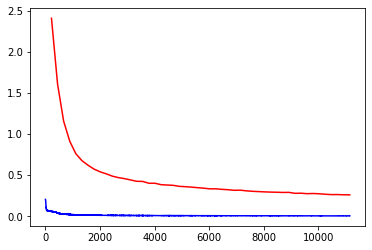

In [11]:
model_cae = ConvAutoencoder().to(device)
optimizer = optim.Adam(model_cae.parameters(), lr=hparams['learning_rate'])
criterion = F.mse_loss

train_losses = []
valid_losses = []
valid_x = []
for epoch in range(1, hparams['num_epochs'] + 1):
    epoch_losses = train(model_cae, 'input', train_loader, optimizer, criterion,
                         device, epoch, hparams['log_interval'])
    train_losses.extend(epoch_losses)

    valid_loss = validate(model_cae, 'input', valid_loader, device)
    valid_losses.append([valid_loss])
    valid_x.append(len(train_losses) - 1)

plt.gcf().clear()
plt.plot(train_losses, 'b-')
plt.plot(valid_x, valid_losses, 'r-')
plt.show()

###Test input comparison

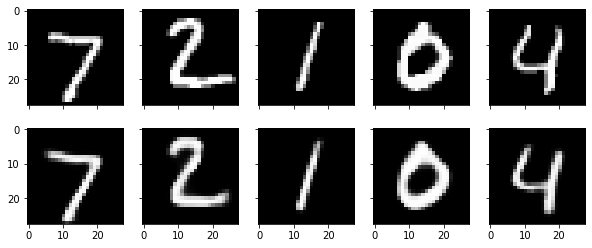

In [0]:
inputs, targets = test_iter.next()
inputs = inputs[:5]
outputs = model_cae(inputs.to(device))
outputs = outputs.detach().cpu().numpy()

show_ae_comparison(inputs, outputs)

###Random input comparison

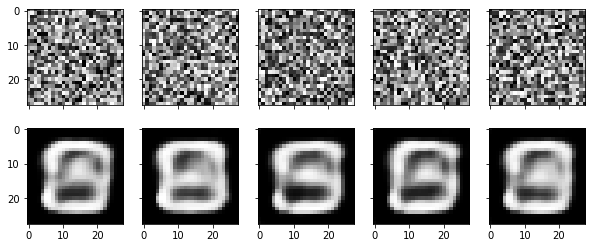

In [0]:
inputs = torch.rand(5,1,28,28)
outputs = model_cae(inputs.to(device))
outputs = outputs.detach().cpu().numpy()

show_ae_comparison(inputs, outputs)

##**Exercise 2** Transfer learning
Reuse autoencoder weights for pre-training and fine-tuning of a classifier trained on a small labeled subset of MNIST.